In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-simplex-999-txt/EN-SIMLEX-999.txt
/kaggle/input/speeches/Book1.xlsx
/kaggle/input/global-economic-indicators-dataset-2010-2023/economic_indicators_dataset_2010_2023.csv
/kaggle/input/iso3-to-country/iso_3digit_alpha_country_codes.xls


In [86]:

df_indicators=pd.read_csv("/kaggle/input/global-economic-indicators-dataset-2010-2023/economic_indicators_dataset_2010_2023.csv",index_col=None)
df_indicators.reset_index(drop=True,inplace=True)
df_speeches=pd.read_excel("/kaggle/input/speeches/Book1.xlsx",index_col=None)
df_speeches.to_excel("Speeches_kaggle.xlsx")
df_speeches.reset_index(drop=True,inplace=True)
df_iso_converter=pd.read_excel("/kaggle/input/iso3-to-country/iso_3digit_alpha_country_codes.xls",index_col=None)
#top(df_speeches)
#print("df_speeches Countries",df_speeches["Country"].unique())
#print("df_indicators Countries",df_indicators["Country"].unique())
#Data exploration stage steps:
#1. Join data sets by date
#2. Add in another data for labeling third word country or not?
#3. Try to explore word representation-vectorizing or some other way,check if there's 
#a score system you can use too
#4. See if you can make own encoder-decoder architectur and use a model of your own
#5. Can part of speech tagging be used as a feature?

In [7]:
df_indicators.head(3)
df_iso_converter.head(3)
df_indicators.head(3)
#print(df_indicators.columns())

,Date,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
0,2010-01-31,Brazil,1.23,0.69,10.48,7.71,21748.85
1,2010-01-31,France,6.76,2.59,4.27,7.39,10039.56
2,2010-01-31,USA,7.46,4.84,2.64,6.39,13129.10


In [87]:
df_speeches[df_speeches["Country"]=="forged in the flames of fickle seasons and overseas markets"]
iso_converter={}
for i in range(len(df_iso_converter)):
    iso_converter[df_iso_converter.loc[i,"ISO 3-Digit Alpha Country Code"]]=df_iso_converter.loc[i,"Unnamed: 1"]
df_speeches["ISO-3 Code"]=df_speeches["Country"] 
country_converted=[]
for i in range(len(df_speeches)):
    if df_speeches.loc[i,"Country"] in iso_converter.keys():
        if df_speeches.loc[i,"Country"]=="USA":
            country_converted.append("USA")
            df_speeches.loc[i,"Country"]="USA"
            next 
        country_converted.append(iso_converter[df_speeches.loc[i,"Country"]])
        df_speeches.loc[i,"Country"]=country_converted[i]
    else:
        country_converted.append("")
print(df_speeches["Country"])

0         Aruba
1         Aruba
2         Aruba
3         Aruba
4         Aruba
          ...  
185458      NaN
185459      NaN
185460      NaN
185461      NaN
185462      NaN
Name: Country, Length: 185463, dtype: object


In [88]:
df_indicators['Date'] = pd.to_datetime(df_indicators['Date'], utc=True)
df_speeches["Date"]= pd.to_datetime(df_speeches['Date'], utc=True)
print("length of df_indicators",len(df_indicators))
print("length of df_speeches",len(df_speeches))
df_merged=pd.merge(df_indicators,df_speeches,on=["Date","Country"])
df_merged.reset_index(drop=True,inplace=True)
print("length of df_merged",len(df_merged))
#print(df_merged.columns())


length of df_indicators 500
length of df_speeches 185463
length of df_merged 55


In [90]:
#Creating target column in df_merged for GDP Increased or not
df_indicators[df_indicators["Country"]=="USA"]
GDP_increase=[]
for i in range(len(df_merged)):
    country=df_merged.loc[i,"Country"]
    date=df_merged.loc[i,"Date"]
    speech_GDP=df_merged.loc[i,"GDP Growth Rate (%)"]
    filtered_df=df_indicators[df_indicators["Country"]==country]
    filtered_df.reset_index(drop=True,inplace=True)
    for r in range(len(filtered_df)):
        if filtered_df.loc[r,"Date"]==date:
            if filtered_df.loc[r-1,"GDP Growth Rate (%)"]>speech_GDP:
                GDP_increase.append("Yes")
            else:
                GDP_increase.append("No")
            break
        
df_merged["GDP_Increase"]=GDP_increase
    

In [91]:
df_merged["GDP_Increase"].value_counts()

GDP_Increase
Yes    28
No     27
Name: count, dtype: int64

In [ ]:
for i in range(len(df_merged["GDP_Increase"])):
    print(df_merged.loc[i,"GDP_Increase"], end=" ")
    print(",")
df_merged['Date'] = pd.to_numeric(pd.to_datetime(df_merged['Date']))

df_merged.to_excel("df_merged.xlsx")

In [92]:
df_speeches.head()
df_indicators.head()
df_merged.head()
print(df_merged["Country"].unique())

['USA' 'Canada' 'India' 'Japan' 'China' 'France' 'Germany' 'Australia']


In [111]:
#Implementing word2vec which involves using neural networks with an input layer, hidden layer and 
#an output layer. 
#The process uses a bag of words(this is where the surrounding words are provided as input), the 
#hidden layer then determines how weant to represent the currrent word.
#Skip Gram: Given the current word as input we try to predict the surrounding words as output via 
#a hidden layer that converts them. 
from gensim.models import Word2Vec
import gensim
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import string

stopwords = nltk.corpus.stopwords.words('english')
#Stemming
ps=nltk.PorterStemmer()

all_sentences = [] #for training Word2Vec models and contain results
tokenized_by_speech=[] #for later use to create a summarized vector of a speech

for text in df_merged["text"]:
    #goes through every speech
    speech=[]
    for sent in sent_tokenize(text):
        #goes through every sentence in speech
        words=[]
        for w in word_tokenize(sent):
            if w.lower() not in stopwords:
                words.append(ps.stem(w.lower()))
            if words:
                speech.append(words)
                all_sentences.append(words)
    tokenized_by_speech.append(speech)
df_merged["tokenized_words"]=tokenized_by_speech
model_cbow=gensim.models.Word2Vec(all_sentences,vector_size=100,window=5,min_count=1)
model_sgram=gensim.models.Word2Vec(all_sentences, vector_size=100,window=5, min_count=1,sg=1)
#a helper function
def get_sentence_vector(sentence_tokens,model):
    vectors=[]
    for word in sentence_tokens:
        if word in model.wv:
            vectors.append(model.wv[word])
            #store vector embedding for each word to have a sentence level emebdding
    if not vectors:
        return np.zeros(model.vector_size)
        #return a mean embedding vector for the speech 
    return np.mean(vectors, axis=0)

speech_embedding_CBOW=[]
speech_embedding_SGram=[]

for speech in df_merged["tokenized_words"]:
    #going through every speech
    for sent in speech:
        #going through every sentence
        sent_vecs_CBOW=get_sentence_vector(sent,model_cbow)
        sent_vecs_SGram=get_sentence_vector(sent,model_sgram)
    if len(sent_vecs_CBOW)>0:
        speech_embedding_CBOW.append(np.mean(sent_vecs_CBOW,axis=0))
        speech_embedding_SGram.append(np.mean(sent_vecs_SGram, axis=0))
    else:
        speech_embedding_CBOW.append(np.zeros(model_cbow.vector_size))
        speech_embedding_SGram.append(np.zeros(model_sgram.vector_size))
df_merged["speech_embedding_CBOW"]=speech_embedding_CBOW
df_merged["speech_embedding_SGram"]=speech_embedding_SGram

In [112]:
from gensim.test.utils import datapath
similarities1=model_cbow.wv.evaluate_word_pairs("/kaggle/input/english-simplex-999-txt/EN-SIMLEX-999.txt")
print(similarities1)

similarities2=model_sgram.wv.evaluate_word_pairs("/kaggle/input/english-simplex-999-txt/EN-SIMLEX-999.txt")
print(similarities2)

(PearsonRResult(statistic=0.008291844860056567, pvalue=0.9115415832003786), SignificanceResult(statistic=-0.010308575472475401, pvalue=0.8901489229626698), 81.78178178178179)
(PearsonRResult(statistic=0.05854039712757818, pvalue=0.43246219380731743), SignificanceResult(statistic=0.03643285667611176, pvalue=0.6253502354609382), 81.78178178178179)


In [ ]:
df_merged["tokenized_words"]

#add in more quotes in from news organizations

In [94]:
import spacy

nlp = spacy.load("en_core_web_sm")

def universal_pos_tagging(text):
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    return pos_tags

df_merged['universal_pos_tags'] = df_merged['text'].apply(universal_pos_tagging)
df_merged.head()
print(df_merged["Country"].unique())

['USA' 'Canada' 'India' 'Japan' 'China' 'France' 'Germany' 'Australia']


In [95]:
from collections import Counter
import matplotlib.pyplot as plt

POS_freq_weighted=[]
POS_freq=[]
overall_POS_counter={}
#saving count of POS relative to total sum across speeches
#creating a counter phrase count for each speech
for speech_pos in df_merged['universal_pos_tags']:
    counts=Counter(tag for word,tag in speech_pos)
    for word,tag in speech_pos:
        if tag not in overall_POS_counter.keys():
            #print(counts[tag])
            overall_POS_counter.update({tag: counts[tag]})
        else:
            overall_POS_counter[tag]+=counts[tag]
    POS_freq.append(counts) #by speech
for speech_pos_count in POS_freq:
    for tag in speech_pos_count:
        speech_pos_count[tag]=speech_pos_count[tag]/overall_POS_counter[tag]
    POS_freq_weighted.append(speech_pos_count)

overall_POS_counter[tag]


4926

In [96]:
df_merged["pos_tag_weighted"]=POS_freq_weighted
df_pos = df_merged["pos_tag_weighted"].apply(pd.Series).fillna(0)


MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [97]:
df_merged=df_merged.join(df_pos)
print(df_merged["Country"].unique())

['USA' 'Canada' 'India' 'Japan' 'China' 'France' 'Germany' 'Australia']


# print(df_merged.loc[54,"pos_tag_weighted"])
#checking how the dataframe looks like 

#print("Unique Countries",df_merged["Country"].unique())

unique_countries=['USA', 'Canada', 'India', 'Japan', 'China', 'France', 'Germany','Australia']

for country in unique_countries:
    #print(df_merged_filtered["pos_tag_weighted"])
    df_merged_filtered=df_merged[df_merged["Country"]==country]
    df_merged_filtered.reset_index(drop=True, inplace=True)
    #get total count for a specific country for each POS
    country_pos_val={}
    for i in range(len(df_merged_filtered)):
        pos_count=df_merged_filtered.loc[i,"pos_tag_weighted"]
        for key in pos_count.keys():
            if key not in country_pos_val.keys():
                country_pos_val.update({key:pos_count[key]})
            else:
                country_pos_val[key]+=pos_count[key]
    categories=list(country_pos_val.keys())
    values=list(country_pos_val.values())
    plt.bar(categories, values)
    plt.title(f'POS Counts for {country}')
    plt.xlabel('POS Tag')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [99]:
df_merged.dtypes
print(df_merged.columns)

Index(['Date', 'Country', 'Inflation Rate (%)', 'GDP Growth Rate (%)',
       'Unemployment Rate (%)', 'Interest Rate (%)', 'Stock Index Value',
       'URL', 'PDF', 'Title', 'Subtitle', 'Authorname', 'Role', 'Gender',
       'CentralBank', 'text', 'text_original', 'Filename', 'Language',
       'Source', 'ISO-3 Code', 'GDP_Increase', 'tokenized_words',
       'speech_embedding_CBOW', 'speech_embedding_SGram', 'universal_pos_tags',
       'pos_tag_weighted', 'PROPN', 'PUNCT', 'VERB', 'NOUN', 'ADP', 'DET',
       'NUM', 'ADJ', 'PRON', 'AUX', 'PART', 'ADV', 'SCONJ', 'CCONJ', 'SPACE',
       'INTJ', 'X', 'SYM'],
      dtype='object')


Accuracy: 0.6428571428571429
ROC AUC Score: 0.7959183673469388
                   feature  importance
0      GDP Growth Rate (%)    0.303512
1    speech_embedding_CBOW    0.155332
2   speech_embedding_SGram    0.076815
18                    INTJ    0.042034
20                     SYM    0.004197
19                       X    0.003939
17                   SPACE    0.002001
15                   SCONJ    0.000578
13                    PART    0.000521
9                      NUM    0.000487


Text(0.5, 427.9555555555555, 'Predicted label')

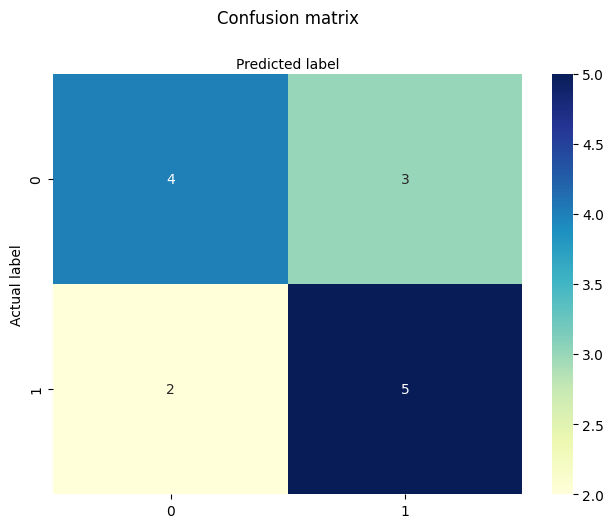

In [100]:
#Logistic regression using word2vec embedding of speecehes and POS tags weighted counts
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.utils import resample

df_majority = df_merged[df_merged["GDP_Increase"]== "Yes"]

df_minority = df_merged[df_merged["GDP_Increase"]== "No"]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])


df_merged['Date'] = pd.to_numeric(pd.to_datetime(df_merged['Date']))

X = df_balanced.select_dtypes(include=['float']).drop(columns=[ 'Unemployment Rate (%)', 'Interest Rate (%)', 'Stock Index Value',"Inflation Rate (%)"])
y = df_balanced["GDP_Increase"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))
y_pred_prob = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f"ROC AUC Score: {auc_score}")

#finding out feature important
feature_importance = np.abs(model.coef_[0])  # Use absolute value
importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": feature_importance
})

importance_df = importance_df.sort_values(by="importance", ascending=False)
print(importance_df.head(10))  # Top 10 most important features


#creating a confusion matrix
y_pred=model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

